In [1]:
import sys
import os

In [2]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

In [3]:
sys.path.append(os.path.join(os.path.abspath('.'), '..'))

from nansy.wav2vec2 import Wav2Vec2Wrapper
_ = sys.path.pop()

In [4]:
import warnings
# for ignoring default initialization future warnings of T-SNE (random to pca)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
SR = 16000
device = torch.device('cuda:0')

In [6]:
LIBRITTS = 'D:/dataset/LibriTTS/test-clean'
speakers = os.listdir(LIBRITTS)[:20]
wavfiles = [
    [
        os.path.join(LIBRITTS, sid, lid, filename)
        for lid in os.listdir(os.path.join(LIBRITTS, sid))
        for filename in os.listdir(os.path.join(LIBRITTS, sid, lid))
        if filename.endswith('.wav')]
    for sid in speakers]

wavs = [
    [
        librosa.load(path, sr=SR)[0]
        for path in lists[:10]]
    for lists in tqdm(wavfiles)]

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
print(speakers)

['1089', '1188', '121', '1221', '1284', '1320', '1580', '1995', '2300', '237', '260', '2830', '2961', '3570', '3575', '3729', '4077', '4446', '4507', '4970']


In [7]:
ids = np.array([
    i
    for i, ws in enumerate(wavs)
    for _ in ws])

cmap = np.array(plt.get_cmap('viridis').colors)
stride = len(cmap) // len(speakers)

In [8]:
model = Wav2Vec2Wrapper()
_ = model.to(device)

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2Model: ['project_hid.weight', 'project_q.weight', 'project_hid.bias', 'quantizer.weight_proj.bias', 'project_q.bias', 'quantizer.weight_proj.weight', 'quantizer.codevectors']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# additional states for pre-transformer layers (positionaal encoding and layer-norm)
vecs = [[] for _ in range(model.model.config.num_hidden_layers + 1)]
for audios in tqdm(wavs):
    # [B]
    lengths = torch.tensor([len(w) for w in audios], dtype=torch.long, device=device)
    # []
    maxlen = lengths.max().item()
    # [B, T]
    auds = torch.tensor(
        np.stack([np.pad(w, [0, maxlen - len(w)]) for w in audios]),
        dtype=torch.float32, device=device)
    # [B, C]
    out = model.forward(auds, audiolen=lengths, return_all=True)
    for i, state in enumerate(out.hidden_states):
        vecs[i].append(state.mean(dim=1).cpu().numpy())

  0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
BASE = 10
WIDTH, HEIGHT = 5, 5

  0%|          | 0/25 [00:00<?, ?it/s]

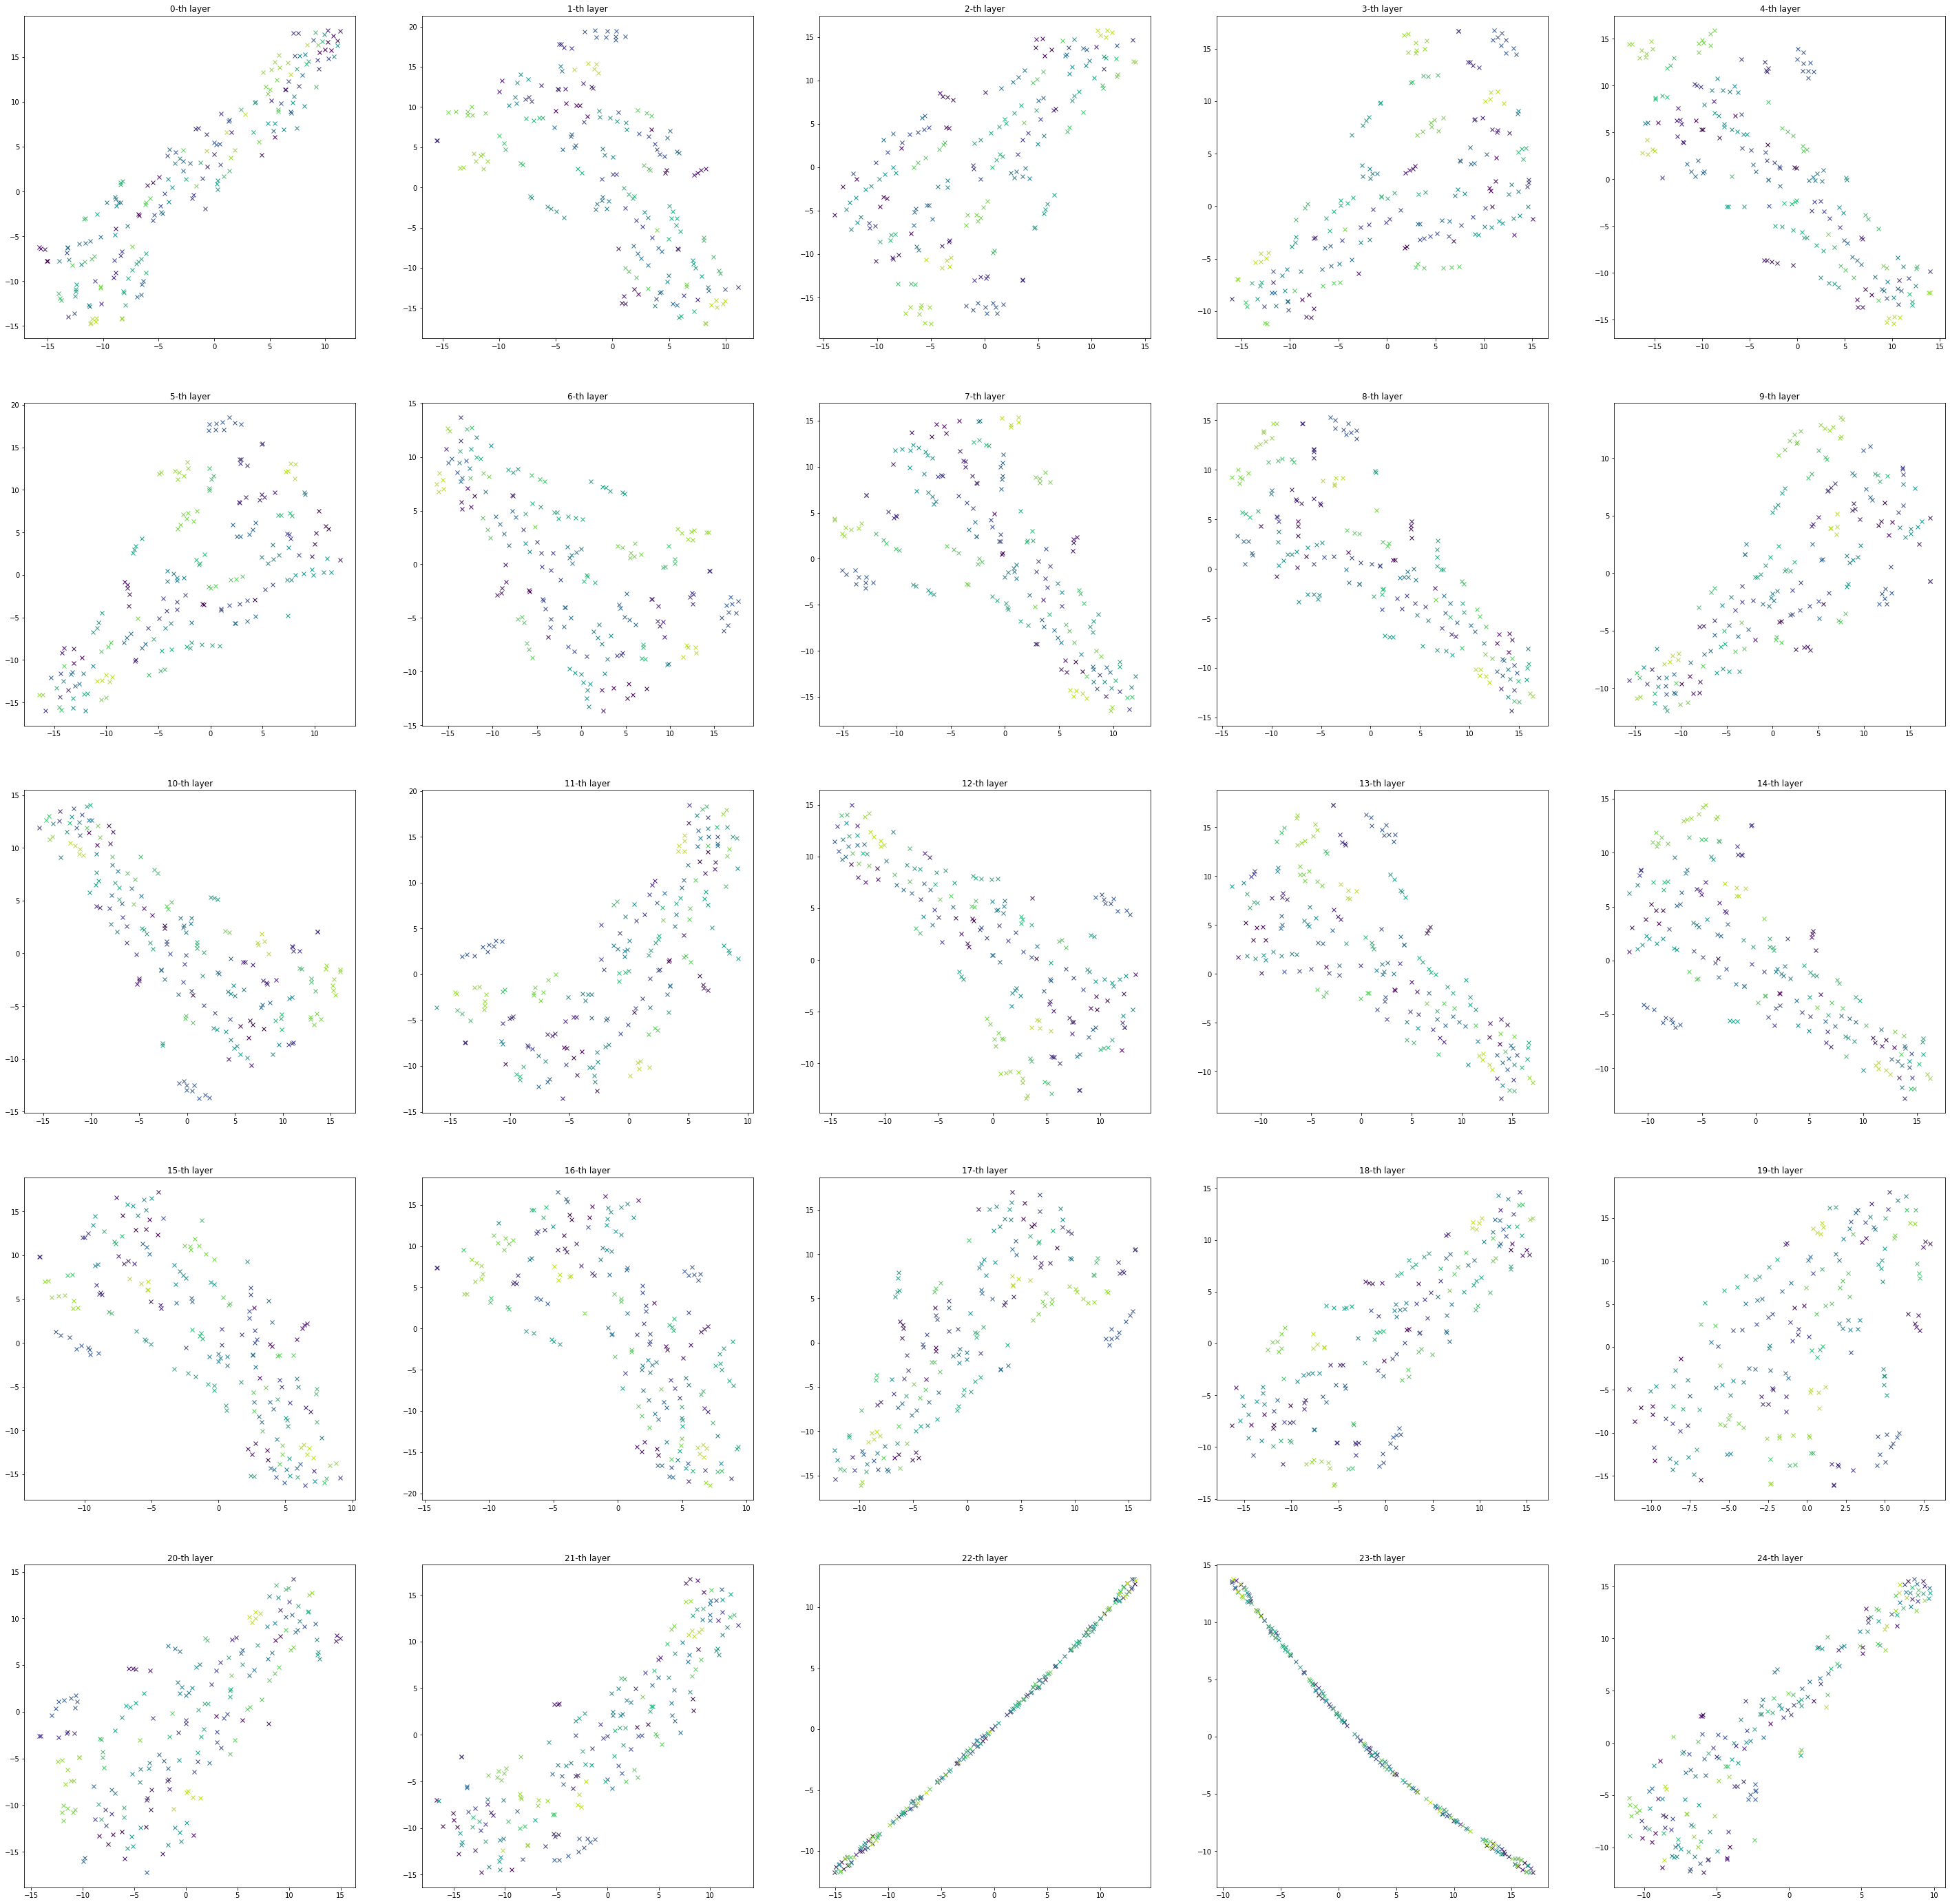

In [11]:
plt.figure(figsize=(BASE * WIDTH, BASE * HEIGHT))
for i, vs in enumerate(tqdm(vecs)):
    vis = TSNE(2).fit_transform(np.concatenate(vs, axis=0))
    plt.subplot(WIDTH, HEIGHT, i + 1)
    plt.title(f'{i}-th layer')
    for j, _ in enumerate(speakers):
        x, y = vis[ids == j].T
        plt.plot(x, y, color=cmap[j * stride], marker='x', linestyle='None')

  0%|          | 0/25 [00:00<?, ?it/s]

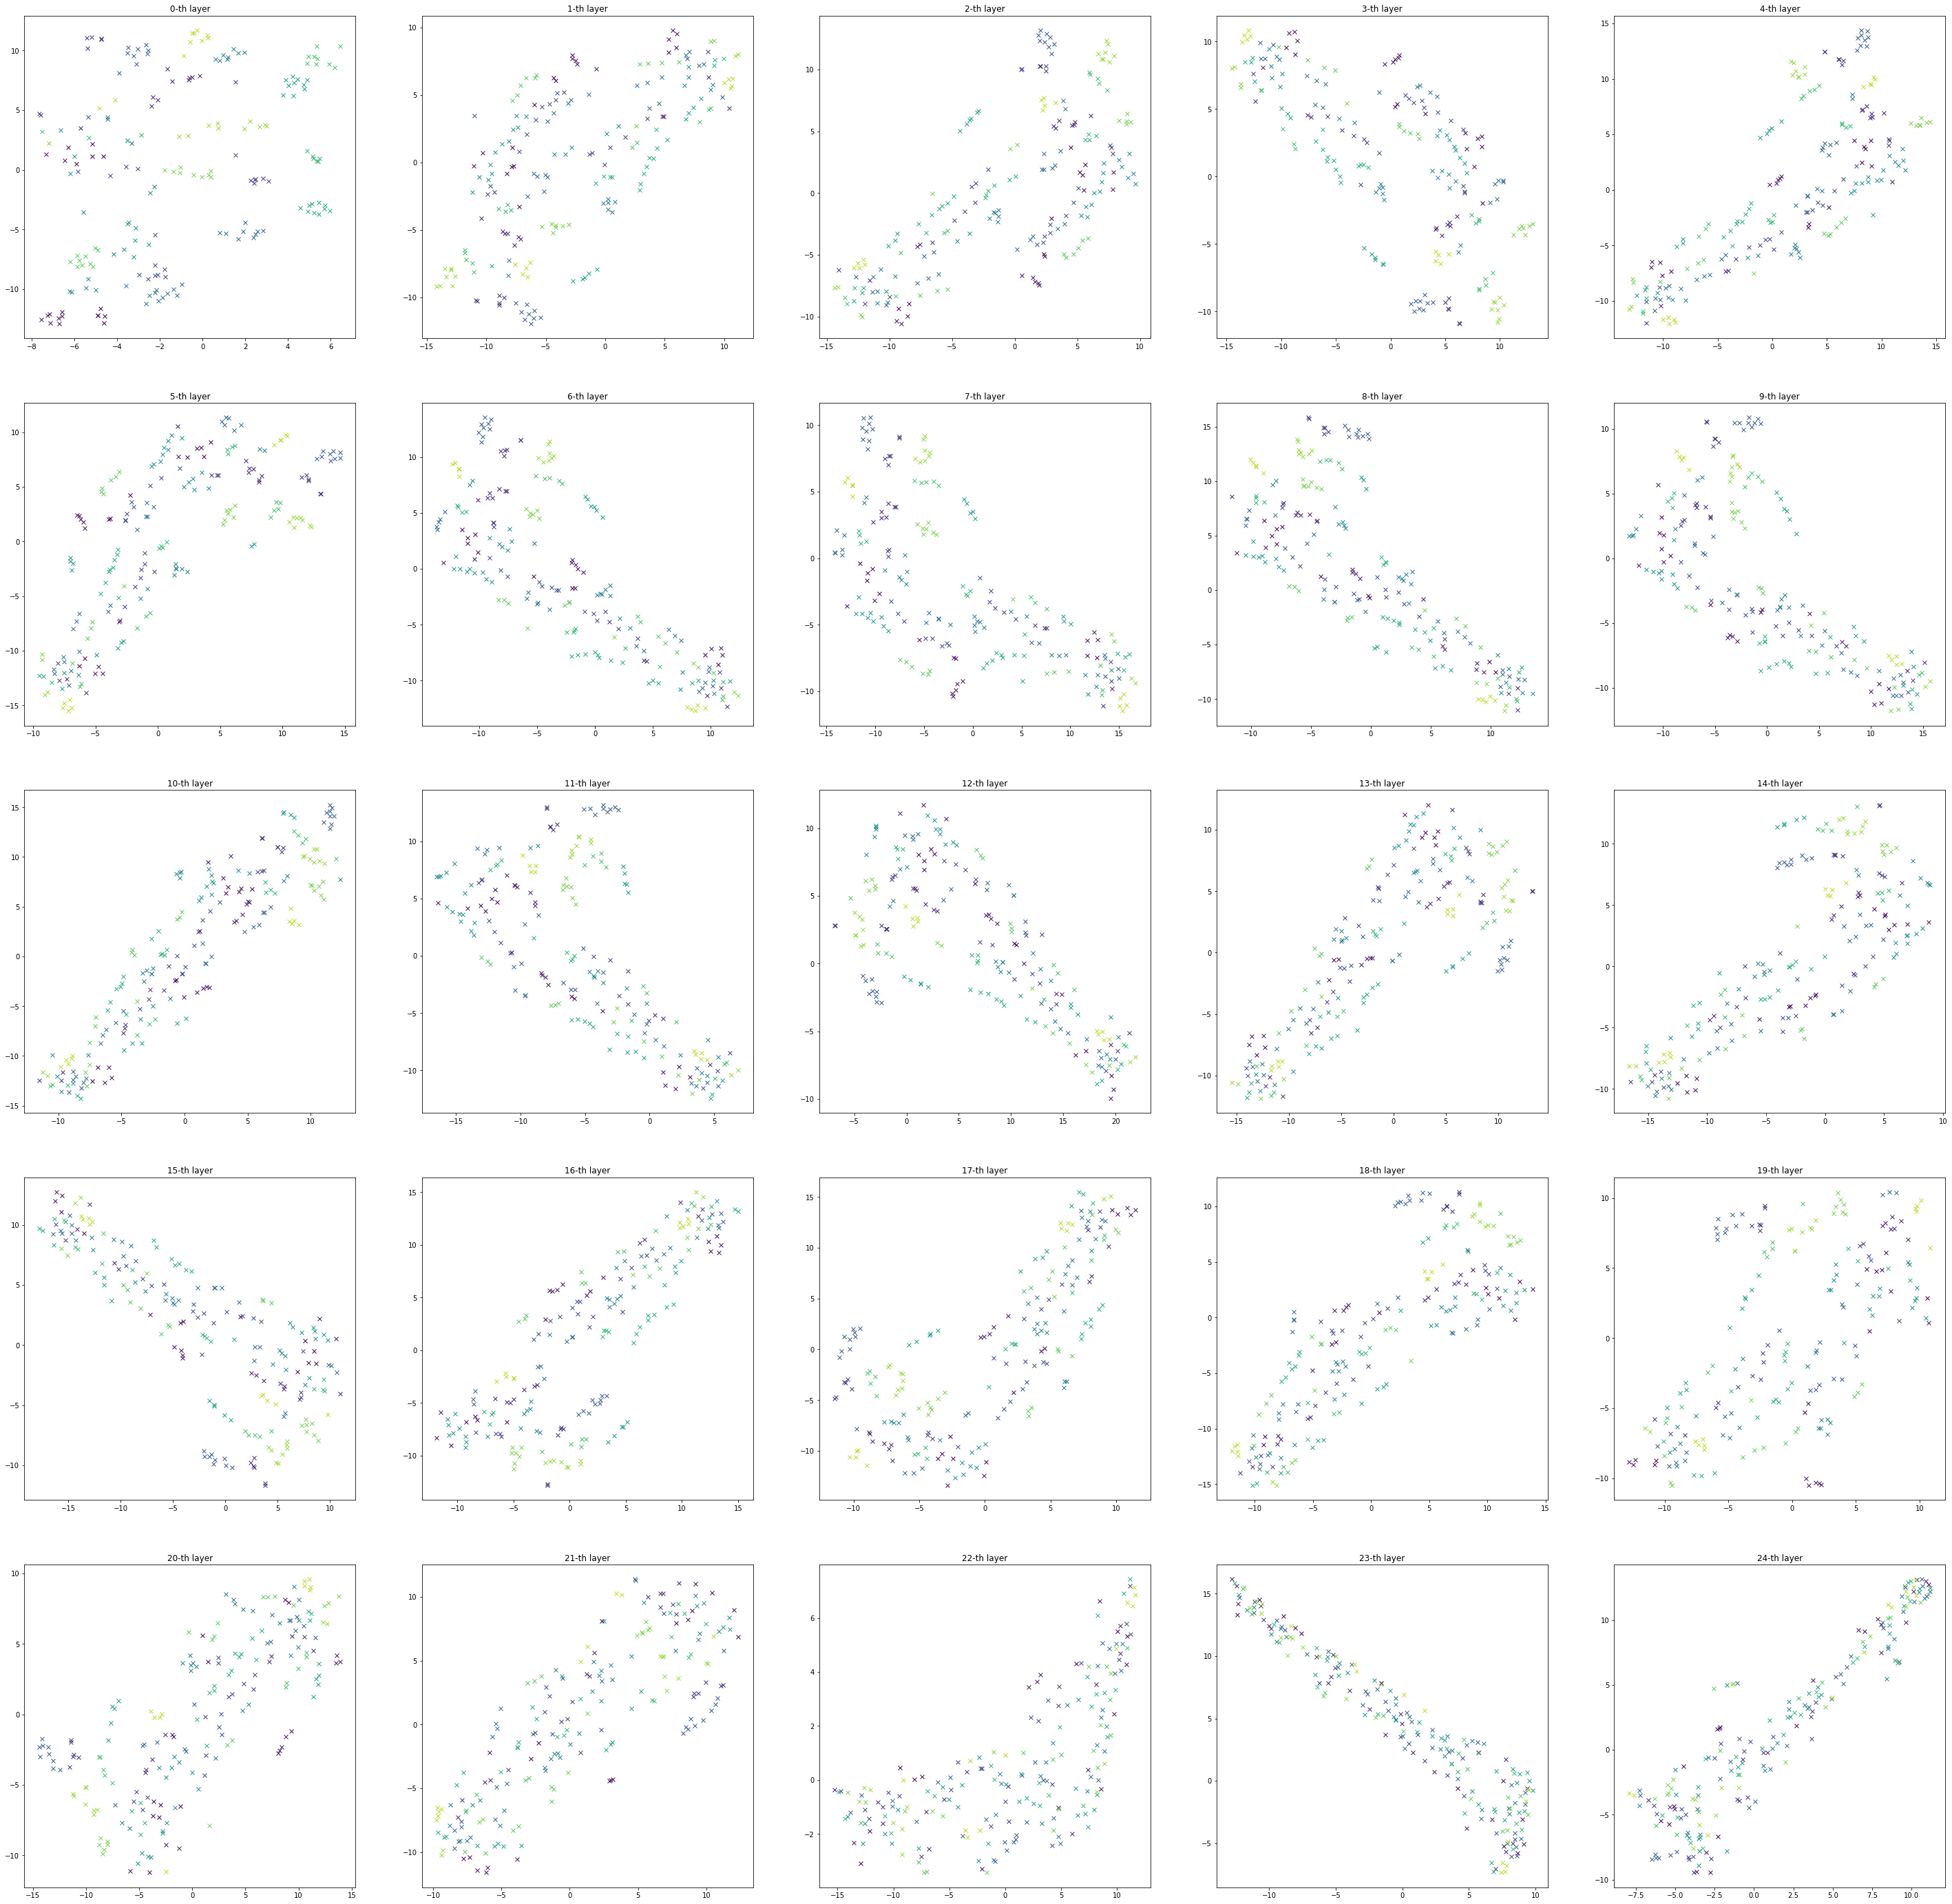

In [12]:
plt.figure(figsize=(BASE * WIDTH, BASE * HEIGHT))
for i, vs in enumerate(tqdm(vecs)):
    # normalize
    vis = TSNE(2, metric='cosine').fit_transform(np.concatenate(vs, axis=0))
    plt.subplot(WIDTH, HEIGHT, i + 1)
    plt.title(f'{i}-th layer')
    for j, _ in enumerate(speakers):
        x, y = vis[ids == j].T
        plt.plot(x, y, color=cmap[j * stride], marker='x', linestyle='None')